In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling
from isca_tools.utils import print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
print(os.getcwd())

/home/users/jamd1/Isca


In [2]:
from get_jasmin_era5 import Find_era5

In [77]:
def split_list_max_n(lst, n):
    """Split lst into balanced chunks with at most n elements each."""
    k = int(np.ceil(len(lst) / n))  # Number of chunks needed
    avg = int(np.ceil(len(lst) / k))
    return [lst[i * avg : (i + 1) * avg] for i in range(k)]

[array([1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11])]

In [86]:
year = 2020
months_all = np.arange(1, 13)
size_chunk = 5
months_chunk = split_list_max_n(months_all, 5)
print(months_chunk)
time_start_chunk = [f"{year}-{i[0]:0d}-01" for i in months_chunk]
time_end_chunk = [f"{year}-{i[0]:0d}-01" for i in months_chunk[1:]]
time_end_chunk = time_start_chunk[1:]
time_end_chunk.append(f"{year+1}-01-01")
print(time_start_chunk)
print(time_end_chunk)

[array([1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11, 12])]
['2020-1-01', '2020-5-01', '2020-9-01']
['2020-5-01', '2020-9-01', '2021-01-01']


In [70]:
months_chunk

[array([1, 2, 3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11])]

In [115]:
%%time
era5 = Find_era5()
var = era5['2t', "2020-02-01":"2020-03-01", None, 0:3, 0:6]

CPU times: user 2.8 s, sys: 1.24 s, total: 4.04 s
Wall time: 9.47 s


In [37]:
era5['pl', "2020-02-01":"2020-02-03", 137, 0:9, -6:6]

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/get_jasmin_era5/core.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


UnboundLocalError: cannot access local variable 'ds' where it is not associated with a value

## Check that sea level pressure and lowest model pressure differ at tibetan plateau
Lowest model level pressure is much lower than mean sea level pressure.

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/get_jasmin_era5/core.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


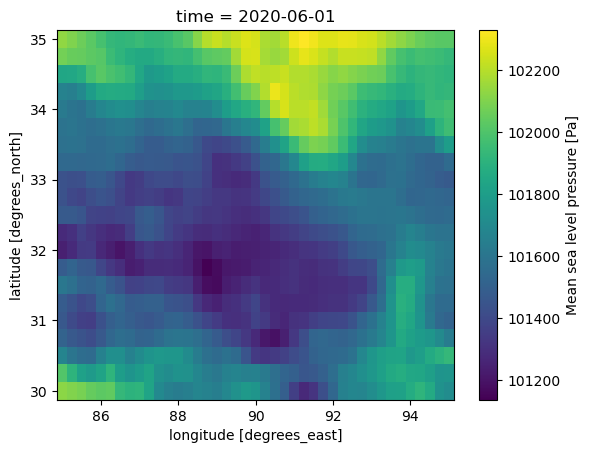

In [104]:
era5['msl', "2020-06-01":"2020-06-02", None, slice(85, 95), slice(30,35)].isel(time=0).msl.plot()

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/get_jasmin_era5/core.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


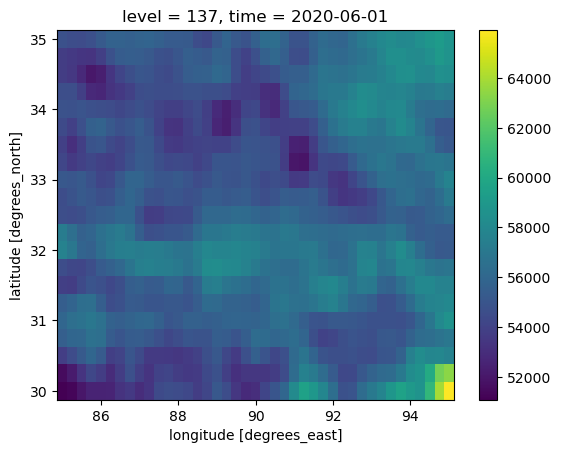

In [88]:
era5.pl["2020-06-01":"2020-06-02", 137, 85:95, 30:35].isel(time=0).plot()

## Compare 2m and lowest model level temperature

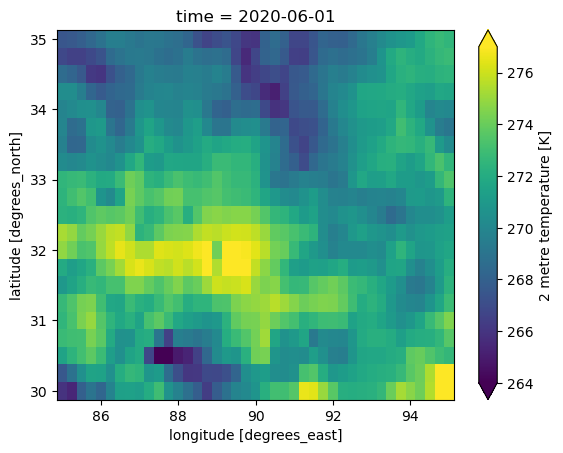

In [52]:
era5['2t', "2020-06-01":"2020-06-02", 137, 85:95, 30:35].isel(time=0).t2m.plot(vmin=264, vmax=277)

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/get_jasmin_era5/core.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


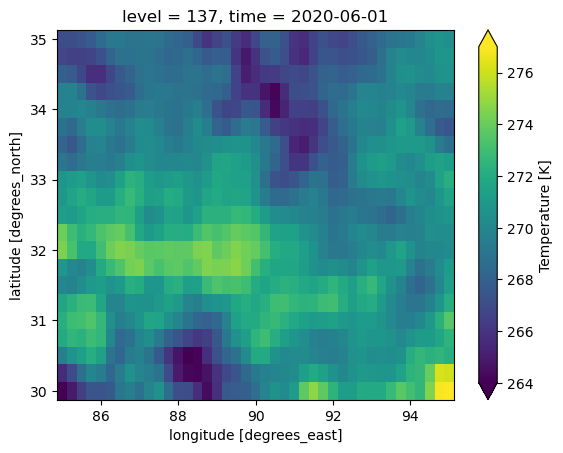

In [53]:
era5['t', "2020-06-01":"2020-06-02", 137, 85:95, 30:35].isel(time=0).t.plot(vmin=264, vmax=277)

# Get invariant value

Need to give a time but can be anything

In [125]:
era5['z', "1900-06-01":"2000-06-02", None, 85:95, 30:35]

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/get_jasmin_era5/core.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


<xarray.Dataset> Size: 7kB
Dimensions:    (longitude: 41, latitude: 21)
Coordinates:
  * longitude  (longitude) float32 164B 85.0 85.25 85.5 ... 94.5 94.75 95.0
  * latitude   (latitude) float32 84B 35.0 34.75 34.5 34.25 ... 30.5 30.25 30.0
Data variables:
    z          (latitude, longitude) float64 7kB dask.array<chunksize=(21, 41), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2018-11-19 10:40:43 GMT by grib_to_netcdf-2.7.3: grib_to_ne...

In [ ]:
era5['2t', "2020-06-01":"2020-06-02", 137, 85:95, 30:35, 'enda']  # ensemble average

In [147]:
getattr(var.resample(time='1D'), 'max')(dim='time')

<xarray.Dataset> Size: 76kB
Dimensions:    (time: 29, latitude: 25, longitude: 13)
Coordinates:
  * longitude  (longitude) float32 52B 0.0 0.25 0.5 0.75 ... 2.25 2.5 2.75 3.0
  * latitude   (latitude) float32 100B 6.0 5.75 5.5 5.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 232B 2020-02-01 2020-02-02 ... 2020-02-29
Data variables:
    t2m        (time, latitude, longitude) float64 75kB dask.array<chunksize=(1, 25, 13), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-19 11:13:39 GMT by grib_to_netcdf-2.14.0: grib_to_n...

In [154]:
era5['2t', "2020-06-01":"2020-06-02", 137, 85:95, 30:35, 'enda']  # ensemble average

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/get_jasmin_era5/core.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


<xarray.Dataset> Size: 55kB
Dimensions:    (time: 8, latitude: 21, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B 85.0 85.25 85.5 ... 94.5 94.75 95.0
  * latitude   (latitude) float32 84B 35.0 34.75 34.5 34.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 64B 2020-06-01 ... 2020-06-01T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 55kB dask.array<chunksize=(1, 21, 41), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-12-22 18:23:26 GMT by grib_to_netcdf-2.19.1: grib_to_n...

In [27]:
%%time
var.resample(time='1D').mean(dim='time')

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 11.3 ms


<xarray.Dataset> Size: 160kB
Dimensions:    (time: 11, latitude: 49, longitude: 37)
Coordinates:
  * longitude  (longitude) float32 148B 0.0 0.25 0.5 0.75 ... 8.25 8.5 8.75 9.0
  * latitude   (latitude) float32 196B 6.0 5.75 5.5 5.25 ... -5.5 -5.75 -6.0
  * time       (time) datetime64[ns] 88B 2020-06-01 2020-06-02 ... 2020-06-11
Data variables:
    t2m        (time, latitude, longitude) float64 160kB 300.8 301.3 ... 297.5
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-05 09:22:30 GMT by grib_to_netcdf-2.17.1: grib_to_n...

In [27]:
# Basic info for getting data on model levels
dir_era5 = '/badc/ecmwf-era5/data/'
id_dataset = 'ecmwf-era5'
id_data = 'data'
id_output = 'oper'      # operatonal as opposed to enda - ensemble data assimilation
id_analysis = 'an'      # use analysis as opposed to forecast
id_level = 'ml'        # use model levels as opposed to surface

In [49]:
year = 1979
month = 1
day = 1
hour = 2      # 2 AM
id_var = 't'        # temperature

In [50]:
def get_file_path(id_var, hour, year, month, day, id_dataset='ecmwf-era5', id_data='data', id_output='oper', id_analysis='an', id_level='ml'):
    dir = f"/badc/{id_dataset}/{id_data}/{id_output}/{id_analysis}_{id_level}/{year}/{month:02d}/{day:02d}"
    file_name = f"{id_dataset}_{id_output}_{id_analysis}_{id_level}_{year}{month:02d}{day:02d}{hour:02d}00.{id_var}.nc"
    return f"{dir}/{file_name}"

In [51]:
ds = xr.load_dataset(get_file_path(id_var, hour, year, month, day))

In [52]:
ds.time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['1979-01-01T02:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 1979-01-01T02:00:00
Attributes:
    long_name:  time